COLD and HINGE features

In [130]:
import imutils
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
import numpy as np
import functools


1- COLD

In [131]:
#define some constants for cold feature extraction 
N_RHO_BINS = 7
N_ANGLE_BINS = 12
N_BINS = N_RHO_BINS * N_ANGLE_BINS
BIN_SIZE = 360 // N_ANGLE_BINS
R_INNER = 5.0
R_OUTER = 35.0
K_S = np.arange(3, 8)

In [132]:
def get_contour_pixels(bw_image):
        contours, _= cv2.findContours(bw_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
        # contours = imutils.grab_contours(contours)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
        
        img2 = bw_image.copy()[:,:,np.newaxis]
        img2 = np.concatenate([img2, img2, img2], axis = 2)
        return contours

In [133]:
def get_cold_features(bw_image, approx_poly_factor = 0.01):
    
        contours = get_contour_pixels(bw_image)
        
        rho_bins_edges = np.log10(np.linspace(R_INNER, R_OUTER, N_RHO_BINS))
        feature_vectors = np.zeros((len(K_S), N_BINS))
        
        # print([len(cnt) for cnt in contours])
        for j, k in enumerate(K_S):
            hist = np.zeros((N_RHO_BINS, N_ANGLE_BINS))
            for cnt in contours:
                epsilon = approx_poly_factor * cv2.arcLength(cnt,True)
                cnt = cv2.approxPolyDP(cnt,epsilon,True)
                n_pixels = len(cnt)
                
                point_1s = np.array([point[0] for point in cnt])
                x1s, y1s = point_1s[:, 0], point_1s[:, 1]
                point_2s = np.array([cnt[(i + k) % n_pixels][0] for i in range(n_pixels)])
                x2s, y2s = point_2s[:, 0], point_2s[:, 1]
                
                thetas = np.degrees(np.arctan2(y2s - y1s, x2s - x1s) + np.pi)
                rhos = np.sqrt((y2s - y1s) ** 2 + (x2s - x1s) ** 2)
                rhos_log_space = np.log10(rhos)
                
                quantized_rhos = np.zeros(rhos.shape, dtype=int)
                for i in range(N_RHO_BINS):
                    quantized_rhos += (rhos_log_space < rho_bins_edges[i])
                    
                for i, r_bin in enumerate(quantized_rhos):
                    theta_bin = int(thetas[i] // BIN_SIZE) % N_ANGLE_BINS
                    hist[r_bin - 1, theta_bin] += 1
                
            normalised_hist = hist / hist.sum()
            feature_vectors[j] = normalised_hist.flatten()
            
        return feature_vectors.flatten()

In [134]:
def Preprocessing (image) : 
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    height, width = image.shape
    img = cv2.GaussianBlur(image, (9, 9), 0) #decrease noise for dialation
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 101, 30)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 101, 30)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 20))
    img = cv2.dilate(img, kernel, iterations=8)
    contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0] 
    biggest_contour = functools.reduce(lambda c1, c2: c1 if cv2.contourArea(c1) > cv2.contourArea(c2) else c2,contours) #find the biggest contour for text area
    x, y, w, h = cv2.boundingRect(biggest_contour) # find smallest rect that can contain the text area after dialation
    image = image[y:y + h, x:x + w]
    return image


C:\Users\DELL\AppData\Local\Temp/ipykernel_6604/901163974.py:23: RuntimeWarning: divide by zero encountered in log10
  rhos_log_space = np.log10(rhos)


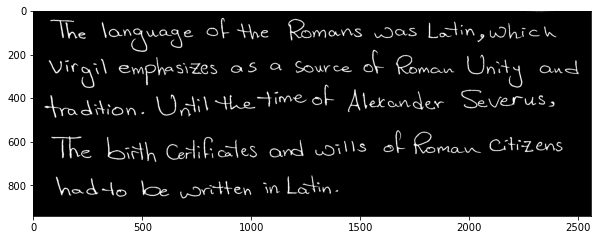

------------------------------------------------------------------------------
total number of features is
420
------------------------------------------------------------------------------
[0.01311375 0.00914913 0.01097896 0.0021348  0.00518451 0.01006404
 0.00914913 0.01189387 0.00701433 0.00365965 0.00426959 0.01128393
 0.01463861 0.00914913 0.01006404 0.0073193  0.00609942 0.01280878
 0.00975907 0.01097896 0.01189387 0.00609942 0.00792925 0.0115889
 0.01128393 0.01036901 0.0094541  0.00609942 0.00914913 0.00853919
 0.00975907 0.01128393 0.01097896 0.0073193  0.00609942 0.01402867
 0.00823422 0.01097896 0.01341873 0.00884416 0.00853919 0.01006404
 0.01006404 0.00609942 0.01097896 0.00670936 0.00487954 0.00823422
 0.00792925 0.00487954 0.00792925 0.00670936 0.00884416 0.00762428
 0.01433364 0.00548948 0.00884416 0.00884416 0.00457457 0.00914913
 0.01860323 0.01646844 0.00884416 0.01341873 0.01433364 0.00975907
 0.02012809 0.01097896 0.00640439 0.01128393 0.01280878 0.021043
 0.031412

In [135]:
image = cv2.imread("..\\Data_split\\train\\Females\\F2.jpg")
img = Preprocessing(image)
cold_features = get_cold_features(img)
fig = plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.show()
print("------------------------------------------------------------------------------")
print("total number of features is")
print(len(cold_features))
print("------------------------------------------------------------------------------")
print(cold_features)


2- HINGE

In [136]:
N_ANGLE_BINS = 40
BIN_SIZE = 360 // N_ANGLE_BINS
LEG_LENGTH = 25

In [137]:
def get_hinge_features(bw_image):
        
        contours = get_contour_pixels(bw_image)
        
        hist = np.zeros((N_ANGLE_BINS, N_ANGLE_BINS))
            
        # print([len(cnt) for cnt in contours])
        for cnt in contours:
            n_pixels = len(cnt)
            if n_pixels <= LEG_LENGTH:
                continue
            
            points = np.array([point[0] for point in cnt])
            xs, ys = points[:, 0], points[:, 1]
            point_1s = np.array([cnt[(i + LEG_LENGTH) % n_pixels][0] for i in range(n_pixels)])
            point_2s = np.array([cnt[(i - LEG_LENGTH) % n_pixels][0] for i in range(n_pixels)])
            x1s, y1s = point_1s[:, 0], point_1s[:, 1]
            x2s, y2s = point_2s[:, 0], point_2s[:, 1]
            
            phi_1s = np.degrees(np.arctan2(y1s - ys, x1s - xs) + np.pi)
            phi_2s = np.degrees(np.arctan2(y2s - ys, x2s - xs) + np.pi)
            
            indices = np.where(phi_2s > phi_1s)[0]
            
            for i in indices:
                phi1 = int(phi_1s[i] // BIN_SIZE) % N_ANGLE_BINS
                phi2 = int(phi_2s[i] // BIN_SIZE) % N_ANGLE_BINS
                hist[phi1, phi2] += 1
                
        normalised_hist = hist / np.sum(hist)
        feature_vector = normalised_hist[np.triu_indices_from(normalised_hist, k = 1)]
        
        return feature_vector

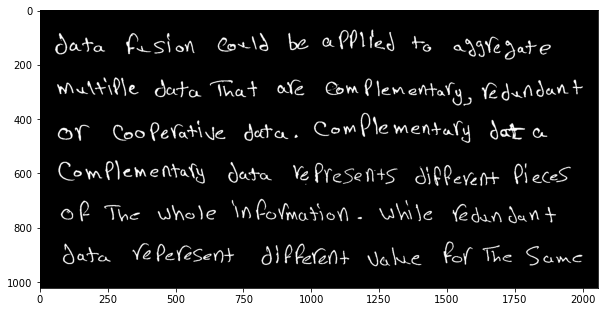

------------------------------------------------------------------------------
total number of features is
420
------------------------------------------------------------------------------
[1.67674711e-03 3.59302952e-04 1.19767651e-04 1.19767651e-04
 4.19186778e-04 2.39535302e-04 2.39535302e-04 1.13779268e-03
 7.18605905e-04 1.13779268e-03 8.98257381e-04 3.59302952e-04
 9.58141206e-04 4.19186778e-04 7.18605905e-04 6.58722079e-04
 1.61686329e-03 5.38954428e-04 1.79651476e-04 8.38373555e-04
 7.78489730e-04 2.99419127e-04 2.99419127e-04 5.98838254e-04
 9.58141206e-04 1.07790886e-03 9.58141206e-04 1.43721181e-03
 6.58722079e-04 1.37732798e-03 6.58722079e-04 4.19186778e-04
 5.38954428e-04 1.13779268e-03 1.25756033e-03 1.31744416e-03
 2.39535302e-03 3.77268100e-03 4.43140308e-03 1.79651476e-03
 7.78489730e-04 5.38954428e-04 4.19186778e-04 1.79651476e-04
 5.38954428e-04 7.18605905e-04 8.98257381e-04 1.07790886e-03
 1.55697946e-03 1.25756033e-03 1.19767651e-03 8.98257381e-04
 1.13779268e-03 6

In [140]:
image = cv2.imread("..\\Data_split\\train\\Males\\M1.jpg")
img = Preprocessing(image)
hinge_features = get_hinge_features(img)
fig = plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.show()
print("------------------------------------------------------------------------------")
print("total number of features is")
print(len(cold_features))
print("------------------------------------------------------------------------------")
print(hinge_features)
